In [91]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import ma
from pathlib import Path
from itertools import chain
import preprocessor 
from importlib import reload
reload(preprocessor)

<module 'preprocessor' from 'C:\\Users\\Alec\\OneDrive\\Documents\\Syracuse\\IST707-DataAnalytics\\project\\preprocessor.py'>

In [92]:
# Preprocessor with Kalman Filtering imputation implementation
pre = preprocessor.Preprocessor()

In [90]:
print(pre.filtered_vals)

None


In [3]:
path = Path('C:/Users/Alec/OneDrive/Documents/Syracuse/IST707-DataAnalytics/project/.data/bejing_air_quality/')

Build up a dictionary of data for each measurement station including the datat and file path

In [4]:
data_files = list(path.glob('*.csv'))
testing_sites = [file_path.parts[-1].split("PRSA_Data")[-1].split("_")[1] for file_path in data_files]

data_dict = {k: {'path': path} for k, path in zip(testing_sites, data_files) }

In [5]:
# Read in each dataset in memory
for station, file in data_dict.items():
    data_dict[station]['df'] = pd.read_csv(file['path'], na_values="NA")

In [7]:
# Add thed summary statistics in the dict
for station, data in data_dict.items():
    df = data['df'] 
    data_dict[station]['summary'] = df.describe()

In [8]:
for station, data in data_dict.items():
    print('*'*30)
    print(station)
    print('*'*30)
    
    for key, items in data.items():
        if key != "df":
            print("="* 5, key, "="* 5)
            print(items)
    break

******************************
Aotizhongxin
******************************
===== path =====
C:\Users\Alec\OneDrive\Documents\Syracuse\IST707-DataAnalytics\project\.data\bejing_air_quality\PRSA_Data_Aotizhongxin_20130301-20170228.csv
===== summary =====
                 No          year         month           day          hour  \
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000   
mean   17532.500000   2014.662560      6.522930     15.729637     11.500000   
std    10122.249256      1.177213      3.448752      8.800218      6.922285   
min        1.000000   2013.000000      1.000000      1.000000      0.000000   
25%     8766.750000   2014.000000      4.000000      8.000000      5.750000   
50%    17532.500000   2015.000000      7.000000     16.000000     11.500000   
75%    26298.250000   2016.000000     10.000000     23.000000     17.250000   
max    35064.000000   2017.000000     12.000000     31.000000     23.000000   

              PM2.5          PM10  

In [9]:
aoti_df = data_dict["Aotizhongxin"]["df"]

In [10]:
aoti_df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [11]:
aoti_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       35064 non-null  int64  
 1   year     35064 non-null  int64  
 2   month    35064 non-null  int64  
 3   day      35064 non-null  int64  
 4   hour     35064 non-null  int64  
 5   PM2.5    34139 non-null  float64
 6   PM10     34346 non-null  float64
 7   SO2      34129 non-null  float64
 8   NO2      34041 non-null  float64
 9   CO       33288 non-null  float64
 10  O3       33345 non-null  float64
 11  TEMP     35044 non-null  float64
 12  PRES     35044 non-null  float64
 13  DEWP     35044 non-null  float64
 14  RAIN     35044 non-null  float64
 15  wd       34983 non-null  object 
 16  WSPM     35050 non-null  float64
 17  station  35064 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 4.8+ MB


In [23]:
aoti_df["Time"] = aoti_df["year"].astype(str) + "-" + aoti_df["month"].astype(str) + "-" + aoti_df["day"].astype(str) + " "+ aoti_df["hour"].astype(str)

In [32]:
aoti_df[["Time"]].head()

,Time
0,2013-3-1 0
1,2013-3-1 1
2,2013-3-1 2
3,2013-3-1 3
4,2013-3-1 4


In [41]:
aoti_df["timestamp"] = pd.to_datetime(aoti_df[['year', 'month', 'day', 'hour']])

In [45]:
aoti_df.set_index("timestamp", inplace=True)

In [68]:
nulls = aoti_df.isnull().sum()
null_cols = nulls[nulls > 0].index.values
null_cols

array(['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'wd', 'WSPM'], dtype=object)

In [75]:
from pandas.api.types import is_numeric_dtype

# df.columns[]
num_bool = [is_numeric_dtype(aoti_df[col]) for col in aoti_df[null_cols].columns]
# for col in aoti_df[null_cols].columns:
#     print(is_numeric_dtype(aoti_df[col]))

In [76]:
num_null_cols = [col for col, tf in zip(aoti_df[null_cols].columns, num_bool) if tf]
num_null_cols

['PM2.5',
 'PM10',
 'SO2',
 'NO2',
 'CO',
 'O3',
 'TEMP',
 'PRES',
 'DEWP',
 'RAIN',
 'WSPM']

In [93]:
arr = pre.kalman_impute(aoti_df["PM10"])

In [100]:
aoti_df["PM10"] = arr

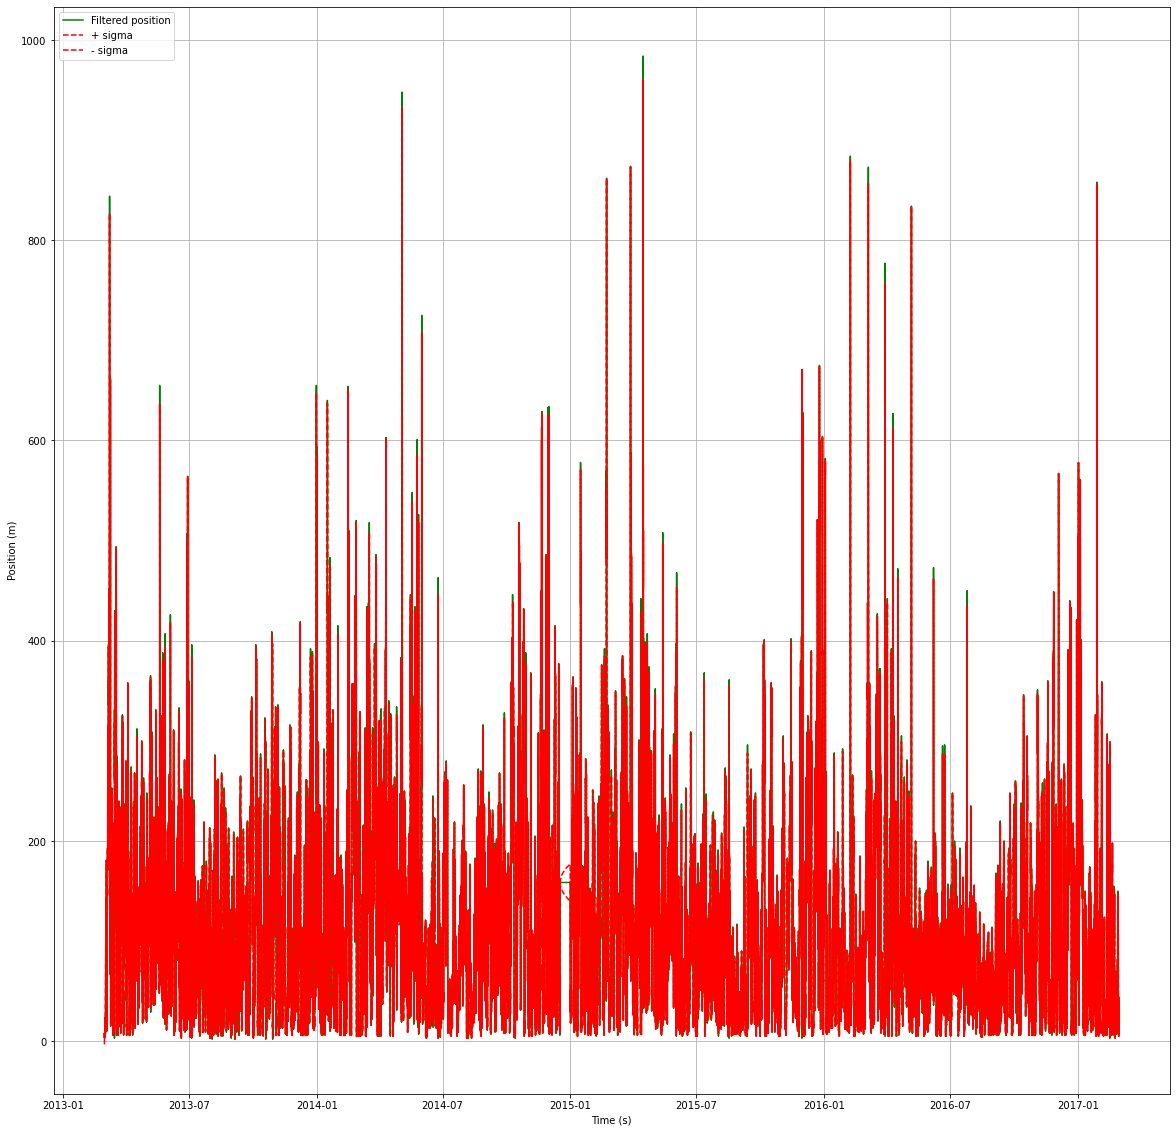

In [112]:
# plot of the resulted trajectory        
fig, ax1 = plt.subplots(1,1, figsize=(20,20))
#axes[0].plot(Time, X.data, "k-", label="Actual", markersize=20)
ax1.plot(arr.index, aoti_df["PM10"].values, "g-", label="Filtered position", markersize=1)
ax1.plot(arr.index, pre.filtered_state_means[:, 0] + pre._sigma, "r--", label="+ sigma", markersize=1)
ax1.plot(arr.index, pre.filtered_state_means[:, 0] - pre._sigma, "r--", label="- sigma", markersize=1)
ax1.grid()
ax1.legend(loc="upper left")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.show()  

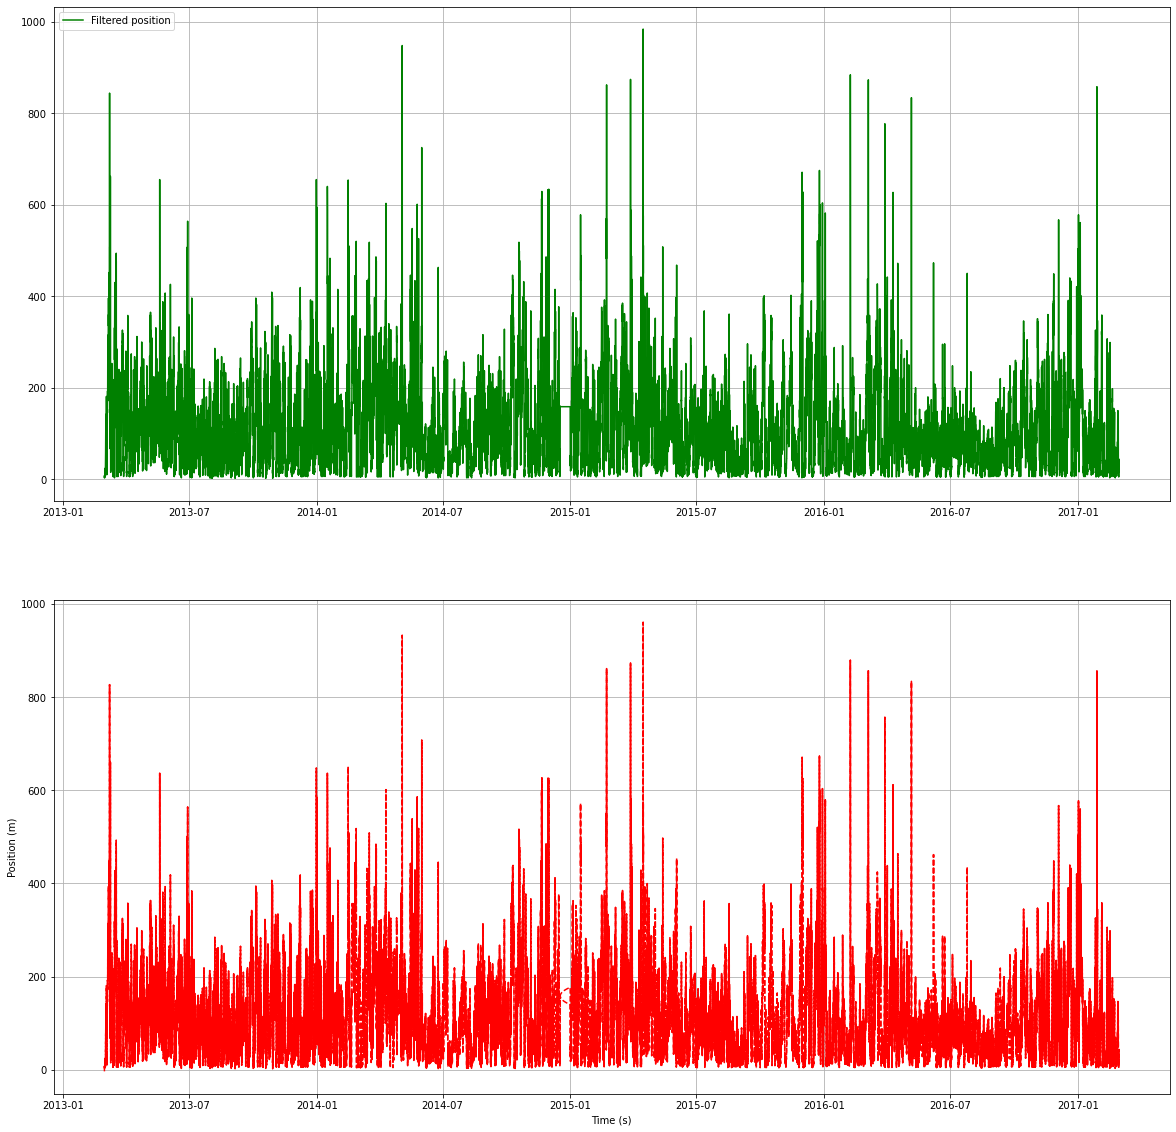

In [101]:
# plot of the resulted trajectory        
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,20))
#axes[0].plot(Time, X.data, "k-", label="Actual", markersize=20)
ax1.plot(arr.index, aoti_df["PM10"].values, "g-", label="Filtered position", markersize=1)
ax.plot(arr.index, pre.filtered_state_means[:, 0] + pre._sigma, "r--", label="+ sigma", markersize=1)
ax2.plot(arr.index, pre.filtered_state_means[:, 0] - pre._sigma, "r--", label="- sigma", markersize=1)
ax1.grid()
ax2.grid()
ax1.legend(loc="upper left")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.show()  

In [113]:
arr[:"2015-01"]

timestamp
2013-03-01 00:00:00      4.0
2013-03-01 01:00:00      8.0
2013-03-01 02:00:00      7.0
2013-03-01 03:00:00      6.0
2013-03-01 04:00:00      3.0
                       ...  
2015-01-31 19:00:00     81.0
2015-01-31 20:00:00    100.0
2015-01-31 21:00:00    119.0
2015-01-31 22:00:00    129.0
2015-01-31 23:00:00    128.0
Length: 16848, dtype: float64

In [105]:
val_counts = aoti_df['wd'].value_counts()
probs = val_counts / val_counts.sum() 

In [111]:
np.array([np.random.choice(val_counts.index.to_numpy(), p=probs, size=(5,)) for _ in range(10)])

array([['NW', 'N', 'NE', 'ENE', 'W'],
       ['ENE', 'NE', 'NE', 'NNE', 'ENE'],
       ['NE', 'NE', 'WSW', 'SSE', 'SSW'],
       ['E', 'ESE', 'WSW', 'WSW', 'NE'],
       ['ENE', 'SSE', 'SE', 'WSW', 'ENE'],
       ['ENE', 'NW', 'E', 'SSW', 'SW'],
       ['N', 'N', 'WSW', 'NW', 'SSW'],
       ['NE', 'E', 'NE', 'SE', 'SSE'],
       ['WNW', 'SW', 'N', 'N', 'NE'],
       ['WSW', 'W', 'SSE', 'WSW', 'SSW']], dtype=object)

### Get the columns with missing data 

In [52]:
nulls = aoti_df.isnull().sum()
nulls[nulls > 0].index.values

array(['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'wd', 'WSPM'], dtype=object)

In [13]:
for key, data in data_dict.items():
    data_dict[key]['null_values'] = data['df'].isnull().sum()
        

In [14]:
# Possible null columns across all 12 datasets 
null_cols = set()

for key, data in data_dict.items():
    null_ser = data_dict[key]['null_values']
    null_cols = null_cols | set(null_ser[null_ser > 0].index.to_list())
  

In [15]:
print(len(null_cols))
print(null_cols)

12
{'O3', 'PRES', 'wd', 'SO2', 'PM10', 'PM2.5', 'WSPM', 'CO', 'RAIN', 'TEMP', 'NO2', 'DEWP'}


In [16]:
len(aoti_df.columns)

18

In [17]:
list(null_cols)

['O3',
 'PRES',
 'wd',
 'SO2',
 'PM10',
 'PM2.5',
 'WSPM',
 'CO',
 'RAIN',
 'TEMP',
 'NO2',
 'DEWP']